In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from matplotlib.colors import LinearSegmentedColormap


In [2]:
def run_decay_analysis(system_root):
    U_path = f"{system_root}/output/lowdin/U_matrix.txt"
    U_matrix = np.loadtxt(U_path)

    if U_matrix.ndim != 2 or U_matrix.shape[0] != U_matrix.shape[1]:
        raise ValueError(f"U must be a square matrix; got shape {U_matrix.shape}")

    num_sites = U_matrix.shape[0]

    # Load geometry and keep only C and N atoms
    xyz_path = f"{system_root}/dft/device/scatt.xyz"
    all_atoms = read(xyz_path)

    is_CN_atom = np.isin(all_atoms.get_chemical_symbols(), ["C", "N"])
    molecular_atoms = all_atoms[is_CN_atom]

    if len(molecular_atoms) < num_sites:
        raise ValueError(
            f"Found only {len(molecular_atoms)} C/N atoms, but U is {num_sites}x{num_sites}."
        )

    site_positions = molecular_atoms.get_positions()

    # Build full distance matrix r_ij
    displacement_vectors = site_positions[:, None, :] - site_positions[None, :, :]
    distance_matrix = np.linalg.norm(displacement_vectors, axis=-1)

    # Prepare colors for each reference site
    site_colors = plt.cm.tab10(np.linspace(0, 1, num_sites))

    # Store alphas for summary
    alphas = np.full(num_sites, np.nan)

    # Loop over reference sites and plot U_ij vs r_ij on log–log scale
    for reference_site in range(num_sites):

        fig, ax = plt.subplots(figsize=(7, 5))

        # All other sites j ≠ i
        partner_sites = np.arange(num_sites)
        partner_sites = partner_sites[partner_sites != reference_site]

        # Distances and interactions from this reference site
        distances_from_i = distance_matrix[reference_site, partner_sites]
        interactions_from_i = U_matrix[reference_site, partner_sites]

        # Sort by increasing distance for cleaner curves
        sort_order = np.argsort(distances_from_i)
        distances_from_i = distances_from_i[sort_order]
        interactions_from_i = interactions_from_i[sort_order]

        # Scatter: U_ij vs r_ij
        ax.loglog(
            distances_from_i,
            interactions_from_i,
            "o",
            color=site_colors[reference_site],
            label=f"site {reference_site + 1}",
        )

        # Reference 1/r line anchored at nearest neighbor
        nearest_distance = distances_from_i[0]
        nearest_interaction = interactions_from_i[0]

        reference_r = np.linspace(distances_from_i.min(), distances_from_i.max(), 200)
        reference_U = nearest_interaction * (nearest_distance / reference_r)

        ax.loglog(
            reference_r,
            reference_U,
            "--",
            color=site_colors[reference_site],
            alpha=0.6,
            label=r"$\propto 1/r$",
        )

        # Fit: U = A * r^{-alpha}
        r_fit = distances_from_i.copy()
        U_fit = interactions_from_i.copy()

        # Keep only positive U (required for log-log fit)
        mask = (r_fit > 0) & (U_fit > 0)
        r_fit = r_fit[mask]
        U_fit = U_fit[mask]

        alpha = np.nan
        A = np.nan

        x = np.log(r_fit)
        y = np.log(U_fit)

        # y = m x + b ; m = -alpha ; b = log(A)
        m, b = np.polyfit(x, y, 1)
        alpha = -m
        A = np.exp(b)
        alphas[reference_site] = alpha

        rline_fit = np.linspace(r_fit.min(), r_fit.max(), 200)
        Uline_fit = A * rline_fit ** (-alpha)
        ax.loglog(
            rline_fit,
            Uline_fit,
            "-",
            color=site_colors[reference_site],
            alpha=0.8,
            label=rf"fit: $\alpha={alpha:.2f}$",
        )

        ax.set_xlabel(r"$r_{ij}$ (Å)")
        ax.set_ylabel(r"$U_{ij}$ (eV)")
        ax.grid(True, which="both", ls=":")
        ax.legend(fontsize=9)

        plt.tight_layout()
        plt.show()

    print(f"\n=== {system_root} ===")
    print("Fitted decay exponents alpha (per reference site):")
    for i, a in enumerate(alphas, start=1):
        print(f"  site {i}: alpha = {a:.3f}" if np.isfinite(a) else f"  site {i}: alpha = n/a")


In [ ]:
run_decay_analysis("../AuBDA13CH2")


## Test of the Spatial Decay of Screened Coulomb Interactions

To assess how the screened Coulomb matrix elements $U_{ij}$ decay with distance, we analyze the off-diagonal interactions as a function of the intersite separation $r_{ij}$. For each reference site $i$, the set of interactions $\{U_{ij}\}_{j \neq i}$ is plotted against the corresponding distances $r_{ij}$ on logarithmic axes.

A log–log representation is used to test whether the decay follows a power law,

$$
U(r) \sim r^{-\alpha}
$$

For each site, a reference line proportional to $1/r$ is overlaid to provide a visual comparison.

To quantify the decay, a power-law fit is performed for each site by fitting the relation

$$
\log U_{ij} = \log A_i - \alpha_i \log r_{ij}
$$



## Results - Pentadienyl

The fitted decay exponents $\alpha_i$ for the seven sites are

- site 1: $\alpha = 0.55$  
- site 2: $\alpha = 0.46$  
- site 3: $\alpha = 0.56$  
- site 4: $\alpha = 0.95$  
- site 5: $\alpha = 0.92$  
- site 6: $\alpha = 0.70$  
- site 7: $\alpha = 0.64$  

For all sites the extracted exponents satisfy $\alpha < 1$, indicating that the screened interaction decays more slowly than $1/r$. The central sites (4 and 5) exhibit exponents close to $\alpha \approx 1$, while the edge and near-edge sites show substantially smaller exponents in the range $\alpha \simeq 0.45$–$0.70$, corresponding to significantly longer-ranged interactions.

Overall, the screened interaction exhibits 

$$
U(r) \sim r^{-\alpha}, \qquad \alpha \approx 0.5\text{–}0.9,
$$

with a site dependence.

## Results - Benzyl

The fitted decay exponents $\alpha_i$ for the nine sites are

- site 1: $\alpha = 0.885$  
- site 2: $\alpha = 0.884$  
- site 3: $\alpha = 0.718$  
- site 4: $\alpha = 0.999$  
- site 5: $\alpha = 1.006$  
- site 6: $\alpha = 0.721$  
- site 7: $\alpha = 0.828$  
- site 8: $\alpha = 0.986$  
- site 9: $\alpha = 0.935$  

The extracted exponents cluster around $\alpha \approx 1$, with values ranging from $\alpha \simeq 0.72$ to $\alpha \simeq 1.01$.

Overall, the screened interaction follows an approximately Coulomb-like power-law decay,

$$
U(r) \sim r^{-\alpha}, \qquad \alpha \approx 0.7\text{–}1.0,
$$

with a weak site dependence.

Compared to the pentadienyl case, where the decay exponents were smaller ($\alpha \approx 0.5$–$0.95$) and indicated more pronounced sub-Coulomb behavior, the benzyl system exhibits more Coulomb-like screening. 



In [3]:
def visualize_reference_sites(
    xyz_path,
    num_sites,
    elements=("C", "N"),
    plane="xy",                # "xy", "xz", or "yz"
    show_all_atoms=True,
    label_every=1,
    highlight_site=None,       # 0-based site index
    figsize=(7, 6),
):
    """
    2D visualization of selected sites with reference-site indexing.
    """

    atoms = read(xyz_path)
    symbols = np.array(atoms.get_chemical_symbols())
    pos_all = atoms.get_positions()

    mask = np.isin(symbols, elements)
    site_atoms = atoms[mask]

    if len(site_atoms) < num_sites:
        raise ValueError(
            f"Found {len(site_atoms)} {elements} atoms, but expected {num_sites} sites."
        )

    # SAME truncation as extract_site_distances
    site_pos = site_atoms.get_positions()[:num_sites]

    plane_map = {
        "xy": (0, 1, "x (Å)", "y (Å)"),
        "xz": (0, 2, "x (Å)", "z (Å)"),
        "yz": (1, 2, "y (Å)", "z (Å)"),
    }

    if plane not in plane_map:
        raise ValueError("plane must be 'xy', 'xz', or 'yz'")

    i0, i1, xl, yl = plane_map[plane]

    fig, ax = plt.subplots(figsize=figsize)

    # Background: all atoms
    if show_all_atoms:
        ax.scatter(
            pos_all[:, i0],
            pos_all[:, i1],
            s=8,
            alpha=0.15,
            color="gray",
            label="all atoms",
        )

    # Selected sites
    ax.scatter(
        site_pos[:, i0],
        site_pos[:, i1],
        s=40,
        alpha=0.9,
        color="tab:blue",
        label="sites",
    )

    # Labels
    for i, (x, y) in enumerate(site_pos[:, [i0, i1]]):
        if label_every > 1 and (i % label_every != 0):
            continue
        ax.text(x, y, f"{i}", fontsize=9, ha="center", va="center")

    # Highlight one site
    if highlight_site is not None:
        if not (0 <= highlight_site < num_sites):
            raise ValueError(f"highlight_site must be in [0, {num_sites-1}]")
        xh, yh = site_pos[highlight_site, [i0, i1]]
        ax.scatter(
            [xh],
            [yh],
            s=160,
            marker="x",
            color="red",
            label=f"reference site i={highlight_site}",
        )

    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Selected sites (C/N), labeled by reference index i")
    ax.legend(frameon=False)
    ax.grid(True, ls=":")

    plt.tight_layout()
    plt.show()

def extract_site_distances(
    xyz_path,
    num_sites,
    elements=("C", "N"),
    only_upper_triangle=True,
):
    """
    Extract site positions and inter-site distances from an XYZ file.

    Parameters
    ----------
    xyz_path : str
        Path to XYZ file.
    num_sites : int
        Number of sites expected (must match U-matrix dimension).
    elements : tuple[str]
        Chemical symbols to keep.
    only_upper_triangle : bool
        If True, returns i<j pairs only.

    Returns
    -------
    positions : (num_sites, 3) ndarray
        Cartesian positions of the sites.
    distance_matrix : (num_sites, num_sites) ndarray
        Full r_ij matrix.
    pair_i, pair_j : ndarray
        Indices of site pairs (for vectorized plotting).
    """

    atoms = read(xyz_path)
    symbols = np.array(atoms.get_chemical_symbols())

    mask = np.isin(symbols, elements)
    mol_atoms = atoms[mask]

    if len(mol_atoms) < num_sites:
        raise ValueError(
            f"Found {len(mol_atoms)} {elements} atoms, but expected {num_sites} sites."
        )

    positions = mol_atoms.get_positions()[:num_sites]

    disp = positions[:, None, :] - positions[None, :, :]
    distance_matrix = np.linalg.norm(disp, axis=-1)

    if only_upper_triangle:
        pair_i, pair_j = np.triu_indices(num_sites, k=1)
    else:
        pair_i, pair_j = np.where(~np.eye(num_sites, dtype=bool))

    return positions, distance_matrix, pair_i, pair_j


def compare_U_vs_distance(
    U_files,
    distance_matrix,
    labels=None,
    reference_site=0,
    loglog=True,
    only_positive=True,
    exclude_self=True,
    figsize=(7, 5),
    alpha_points=0.8,
    s=18,
    connect=False,
    save_data=True,
    output_path="U_vs_r.txt",
):
    """
    Plot U_{i,j} vs r_{i,j} for a single reference site i, overlaying multiple U matrices.
    Optionally write the plotted data to disk.
    """

    def load_U(path):
        U = np.loadtxt(path)
        if U.ndim != 2 or U.shape[0] != U.shape[1]:
            raise ValueError(f"U must be square; got {U.shape}")
        return U

    U_mats = [load_U(f) for f in U_files]
    num_sites = U_mats[0].shape[0]

    for U in U_mats:
        if U.shape != (num_sites, num_sites):
            raise ValueError("All U matrices must have the same shape")

    if not (0 <= reference_site < num_sites):
        raise ValueError(f"reference_site must be in [0, {num_sites-1}]")

    if labels is None:
        labels = [f.split("/")[-1] for f in U_files]

    # partner indices j
    partners = np.arange(num_sites)
    if exclude_self:
        partners = partners[partners != reference_site]

    # distances r_{i,j}
    r_i = distance_matrix[reference_site, partners]

    # sort by distance
    order = np.argsort(r_i)
    partners = partners[order]
    r_i = r_i[order]

    fig, ax = plt.subplots(figsize=figsize)

    # store data for output
    data_cols = [partners, r_i]

    for U, lab in zip(U_mats, labels):
        u_i = U[reference_site, partners]

        mask = np.isfinite(r_i) & np.isfinite(u_i)
        if only_positive:
            mask &= (r_i > 0) & (u_i > 0)

        rr = r_i[mask]
        uu = u_i[mask]

        marker = "o-" if connect else "o"
        if loglog:
            ax.loglog(rr, uu, marker, markersize=np.sqrt(s),
                      alpha=alpha_points, label=lab)
        else:
            ax.plot(rr, uu, marker, markersize=np.sqrt(s),
                    alpha=alpha_points, label=lab)

        data_cols.append(uu)

    ax.set_title(f"Reference site i = {reference_site}")
    ax.set_xlabel(r"$r_{ij}$ (Å)")
    ax.set_ylabel(r"$U_{ij}$ (eV)")
    ax.grid(True, which="both", ls=":")
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

    # ---------- write data ----------
    if save_data:
        header = ["j", "r_ij[Å]"] + [f"U_{lab}[eV]" for lab in labels]
        table = np.column_stack(data_cols)

        np.savetxt(
            output_path,
            table,
            header="  ".join(header),
            fmt=["%4d", "%.6f"] + ["%.8f"] * len(labels),
        )

        print(f"Saved U(r) data to: {output_path}")

def plot_U_matrices(
    U_files,
    site_labels=None,          # e.g. ["N","C","C",...]
    titles=None,               # subplot titles
    vmins=None,                # list or None
    vmaxs=None,                # list or None
    figsize=(14, 5),
    output=None,
):
    """
    Plot multiple U matrices side by side with individual colorbars and scaling.
    """

    # ---- load matrices
    U_mats = [np.loadtxt(f) for f in U_files]

    for i, U in enumerate(U_mats):
        if U.ndim != 2 or U.shape[0] != U.shape[1]:
            raise ValueError(f"U matrix {U_files[i]} must be square; got {U.shape}")

    n = U_mats[0].shape[0]
    for U in U_mats:
        if U.shape != (n, n):
            raise ValueError("All U matrices must have the same shape")

    if site_labels is not None and len(site_labels) != n:
        raise ValueError("site_labels length must match U dimension")

    nplots = len(U_mats)

    if titles is None:
        titles = [f.split("/")[-1] for f in U_files]
    if len(titles) != nplots:
        raise ValueError("titles must match number of U files")

    if vmins is None:
        vmins = [np.min(U) for U in U_mats]
    if vmaxs is None:
        vmaxs = [np.max(U) for U in U_mats]

    if len(vmins) != nplots or len(vmaxs) != nplots:
        raise ValueError("vmins and vmaxs must match number of U files")

    # ---- custom pink/mauve colormap
    cmap = LinearSegmentedColormap.from_list(
        "rose",
        ["#fff7f7", "#e6b3b3", "#c97a7a", "#9e4f6f"],
        N=256,
    )

    fig, axes = plt.subplots(1, nplots, figsize=figsize)

    if nplots == 1:
        axes = [axes]

    for ax, U, title, vmin, vmax in zip(axes, U_mats, titles, vmins, vmaxs):
        im = ax.imshow(
            U,
            cmap=cmap,
            origin="upper",
            vmin=vmin,
            vmax=vmax,
        )

        # grid
        ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
        ax.grid(which="minor", color="black", linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)

        # ticks
        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(n))

        if site_labels is not None:
            ax.set_xticklabels(site_labels)
            ax.set_yticklabels(site_labels)
        else:
            ax.set_xticklabels(range(n))
            ax.set_yticklabels(range(n))

        ax.set_title(title)
        ax.set_xlabel("site j")
        ax.set_ylabel("site i")

        # individual colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(r"$U_{ij}$ (eV)")


    if output is not None:
        plt.savefig(output, dpi=300)
        print(f"Saved U-matrix comparison to: {output}")

    plt.show()


In [4]:
U_ref = np.loadtxt("../output/lowdin/U_matrix_crpa.txt")
num_sites = U_ref.shape[0]

positions, r_matrix, pi, pj = extract_site_distances(
    xyz_path="../dft/device/scatt.xyz",
    num_sites=num_sites,
)

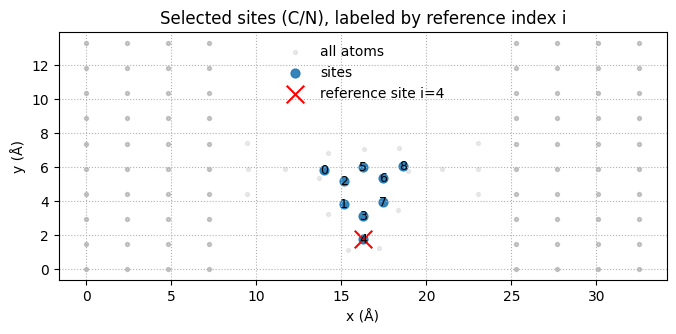

In [5]:
visualize_reference_sites(
    xyz_path="../dft/device/scatt.xyz",
    num_sites=num_sites,
    show_all_atoms=True,
    label_every=1,
    highlight_site=4,
)


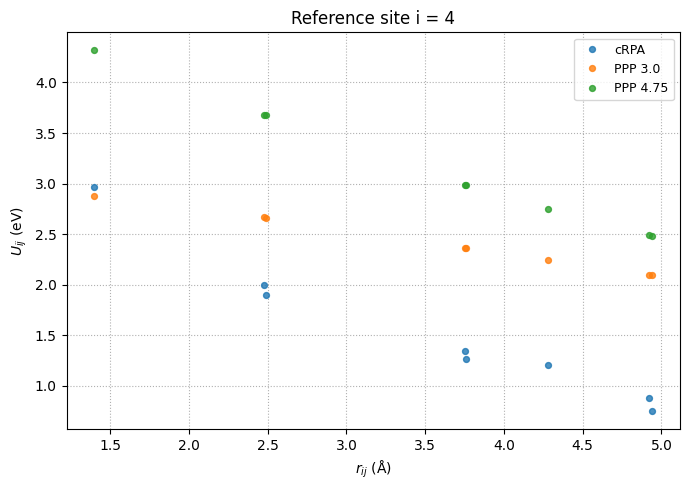

Saved U(r) data to: ../output/lowdin/U_vs_r_radical_C.txt


In [6]:
compare_U_vs_distance(
    U_files=["../output/lowdin/U_matrix_crpa.txt", "../output/lowdin/U_matrix_PPP_U_3.0.txt", "../output/lowdin/U_matrix_PPP_U_mean.txt"],
    distance_matrix=r_matrix,
    labels=["cRPA", "PPP 3.0", "PPP 4.75"],
    reference_site=4,
    loglog=False,
    connect=False,
    save_data=True,
    output_path="../output/lowdin/U_vs_r_radical_C.txt",
)


Saved U-matrix comparison to: ../output/lowdin/U_matrix_comparison.png


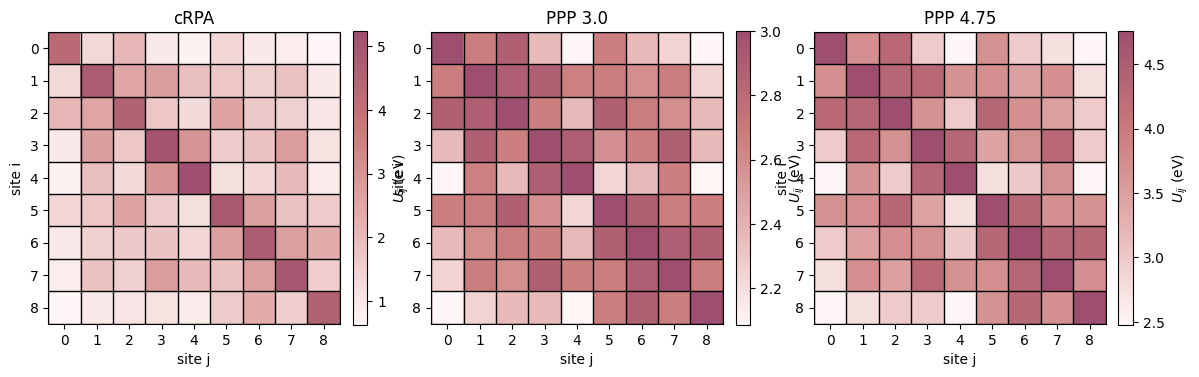

In [7]:
plot_U_matrices(
    U_files=[
        "../output/lowdin/U_matrix_crpa.txt",
        "../output/lowdin/U_matrix_PPP_U_3.0.txt",
        "../output/lowdin/U_matrix_PPP_U_mean.txt",
    ],
    titles=["cRPA", "PPP 3.0", "PPP 4.75"],
    output="../output/lowdin/U_matrix_comparison.png",
)